In [1]:
# -*- coding: utf-8 -*-
"""withlocation.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1T0QirBObO6kAO1YSBV7PHyYzfnUUB7-K
"""

import pandas as pd
from sklearn.model_selection import train_test_split
import re
from sklearn import preprocessing
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer,TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
import string
import re
import spacy
import contextualSpellCheck
from sklearn.pipeline import Pipeline
import matplotlib
from imblearn.over_sampling import RandomOverSampler


In [2]:
# !python -m spacy download en_core_web_lg


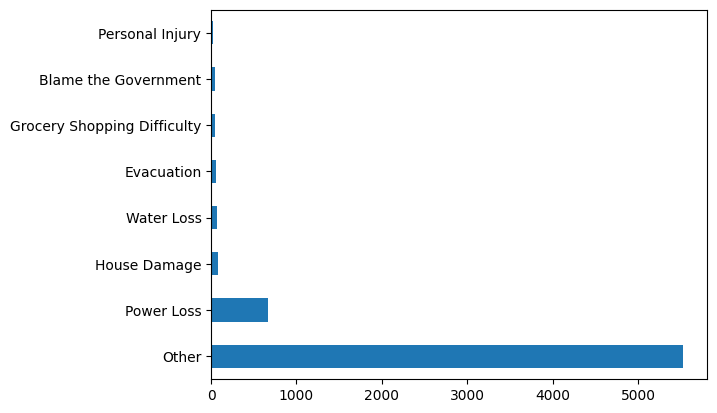

In [3]:
def  prune_text(df, text_field):
    df[text_field] = df[text_field].str.lower()
    df[text_field] = df[text_field].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", elem))  
    return df

data = pd.read_csv("data.csv")
location = pd.read_csv("louisiana_city.csv")
data.rename(columns={'New Classification':'label'},inplace=True)
data['cordinates'] = data['geo'].str[:-6]
required_columns = ['cordinates','tweet','label']
required_data = data[required_columns]
required_data = required_data[required_data.label != 'New Classification']
required_data.label.value_counts().plot(kind='barh')
le = preprocessing.LabelEncoder()
required_data['label'] = le.fit_transform(required_data['label'])
required_data[['x_cor','y_cor']] = required_data.cordinates.str.split(",",expand=True)
required_data = prune_text(required_data,'tweet')
required_data.drop(columns=['cordinates'],inplace=True)
required_data['x_cor'] = required_data['x_cor'].str.strip()
required_data['y_cor'] = required_data['y_cor'].str.strip()
location['Latitude'] = location['Latitude'].astype(str).str.strip()
location['Longitude'] = location['Longitude'].astype(str).str.strip()
location_data = pd.merge(required_data, location,  how='left', left_on=['x_cor','y_cor'], right_on = ['Latitude','Longitude'])
final_data = location_data[['tweet','Location','label']]
final_data.dropna(inplace=True)

In [3]:
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(final_data[['tweet']], final_data[['label']].astype(str))
resampled_final_data = pd.concat([X_resampled, y_resampled],axis=1)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(resampled_final_data[['tweet']],resampled_final_data['label'],test_size=0.2, random_state = 0,stratify=resampled_final_data['label'])

In [6]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn import set_config


In [7]:
column_trans = ColumnTransformer([('tweet', TfidfVectorizer(), 'tweet')],remainder='drop', verbose_feature_names_out=False)

In [8]:
nb = MultinomialNB()

In [9]:
univariate_nb_pipe1 = Pipeline([('column_trans', column_trans), ('nb', nb)])
univariate_nb_pipe1.fit(X_train, y_train)
y_preds_uni_nb = univariate_nb_pipe1.predict(X_test)

In [10]:
set_config(display="diagram")
univariate_nb_pipe1 

Pipeline(steps=[('column_trans',
                 ColumnTransformer(transformers=[('tweet', TfidfVectorizer(),
                                                  'tweet')],
                                   verbose_feature_names_out=False)),
                ('nb', MultinomialNB())])

In [11]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

classes = [x for x in list(le.classes_) if str(x) != 'nan']
classes.append("unrecognised")

In [12]:
print("Model Name: Naive Bayes")
print("Accuracy: "+ str(accuracy_score(y_test, y_preds_uni_nb)*100))
print(classification_report(y_test,y_preds_uni_nb, target_names=classes))


Model Name: Naive Bayes
Accuracy: 95.26104417670683
                             precision    recall  f1-score   support

       Blame the Government       0.97      1.00      0.98      1107
                 Evacuation       0.97      1.00      0.98      1106
Grocery Shopping Difficulty       0.98      1.00      0.99      1106
               House Damage       0.93      1.00      0.96      1107
                      Other       0.98      0.60      0.74      1107
            Personal Injury       0.99      1.00      0.99      1107
                 Power Loss       0.84      0.97      0.90      1107
                 Water Loss       0.96      1.00      0.98      1106
               unrecognised       0.99      1.00      0.99      1107

                   accuracy                           0.95      9960
                  macro avg       0.96      0.95      0.95      9960
               weighted avg       0.96      0.95      0.95      9960



In [134]:
from sklearn.tree import DecisionTreeClassifier

In [135]:
dt = DecisionTreeClassifier(random_state=0, max_depth=10)
univariate_dt_pipe = Pipeline([('column_trans', column_trans), ('dt', dt)])
univariate_dt_pipe.fit(X_train, y_train)
y_preds_univariate_dt = univariate_dt_pipe.predict(X_test)

In [136]:
univariate_dt_pipe

Pipeline(steps=[('column_trans',
                 ColumnTransformer(transformers=[('tweet', TfidfVectorizer(),
                                                  'tweet')],
                                   verbose_feature_names_out=False)),
                ('dt', DecisionTreeClassifier(max_depth=10, random_state=0))])

In [137]:
print("Model Name: Decision Tree")
print("Accuracy: "+ str(accuracy_score(y_test, y_preds_univariate_dt)*100))
print(classification_report(y_test,y_preds_univariate_dt, target_names=classes))


Model Name: Decision Tree
Accuracy: 59.23694779116466
                             precision    recall  f1-score   support

       Blame the Government       0.24      0.96      0.39      1107
                 Evacuation       0.99      0.46      0.63      1106
Grocery Shopping Difficulty       0.99      0.44      0.61      1106
               House Damage       0.97      0.44      0.61      1107
                      Other       1.00      0.02      0.05      1107
            Personal Injury       1.00      0.59      0.74      1107
                 Power Loss       0.92      0.73      0.81      1107
                 Water Loss       0.60      0.91      0.72      1106
               unrecognised       1.00      0.78      0.87      1107

                   accuracy                           0.59      9960
                  macro avg       0.86      0.59      0.60      9960
               weighted avg       0.86      0.59      0.60      9960



In [28]:
from sklearn.neural_network import MLPClassifier

In [29]:
mlp = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(500, 20), random_state=1)
univariate_mlp_pipe = Pipeline([('column_trans', column_trans), ('mlp', mlp)])
univariate_mlp_pipe.fit(X_train, y_train)
y_preds_univariate_nlp = univariate_mlp_pipe.predict(X_test)


In [30]:
univariate_mlp_pipe

Pipeline(steps=[('column_trans',
                 ColumnTransformer(transformers=[('tweet', TfidfVectorizer(),
                                                  'tweet')],
                                   verbose_feature_names_out=False)),
                ('mlp',
                 MLPClassifier(alpha=1e-05, hidden_layer_sizes=(500, 20),
                               random_state=1, solver='lbfgs'))])

In [31]:
print("Model: Multi Layer Perceptron" )
print("Accuracy: "+ str(accuracy_score(y_test, y_preds_univariate_nlp)*100))
print(classification_report(y_test,y_preds_univariate_nlp, target_names=classes))


Model: Multi Layer Perceptron
Accuracy: 99.31726907630522
                             precision    recall  f1-score   support

       Blame the Government       1.00      1.00      1.00      1107
                 Evacuation       1.00      1.00      1.00      1106
Grocery Shopping Difficulty       1.00      1.00      1.00      1106
               House Damage       1.00      1.00      1.00      1107
                      Other       1.00      0.94      0.97      1107
            Personal Injury       1.00      1.00      1.00      1107
                 Power Loss       0.96      1.00      0.98      1107
                 Water Loss       0.99      1.00      1.00      1106
               unrecognised       1.00      1.00      1.00      1107

                   accuracy                           0.99      9960
                  macro avg       0.99      0.99      0.99      9960
               weighted avg       0.99      0.99      0.99      9960



In [32]:
from sklearn.multiclass import OutputCodeClassifier
from sklearn.svm import LinearSVC

In [33]:
mlc = OutputCodeClassifier(LinearSVC(random_state=0),code_size=6, random_state=0)
univariate_mlc_pipe = Pipeline([('column_trans', column_trans), ('mlc', mlc)])
univariate_mlc_pipe.fit(X_train, y_train)
y_preds_univariate_mlc = univariate_mlc_pipe.predict(X_test)


In [34]:
univariate_mlc_pipe

Pipeline(steps=[('column_trans',
                 ColumnTransformer(transformers=[('tweet', TfidfVectorizer(),
                                                  'tweet')],
                                   verbose_feature_names_out=False)),
                ('mlc',
                 OutputCodeClassifier(code_size=6,
                                      estimator=LinearSVC(random_state=0),
                                      random_state=0))])

In [35]:
print("Model: Multi Class Classifier" )
print("Accuracy: "+ str(accuracy_score(y_test, y_preds_univariate_nlp)*100))
print(classification_report(y_test,y_preds_univariate_mlc, target_names=classes))


Model: Multi Class Classifier
Accuracy: 99.31726907630522
                             precision    recall  f1-score   support

       Blame the Government       1.00      1.00      1.00      1107
                 Evacuation       1.00      1.00      1.00      1106
Grocery Shopping Difficulty       1.00      1.00      1.00      1106
               House Damage       1.00      1.00      1.00      1107
                      Other       1.00      0.92      0.96      1107
            Personal Injury       1.00      1.00      1.00      1107
                 Power Loss       0.94      1.00      0.97      1107
                 Water Loss       0.99      1.00      1.00      1106
               unrecognised       1.00      1.00      1.00      1107

                   accuracy                           0.99      9960
                  macro avg       0.99      0.99      0.99      9960
               weighted avg       0.99      0.99      0.99      9960



In [1]:
!pip3 install wordcloud

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.5/160.5 kB 2.3 MB/s eta 0:00:00 MB/s eta 0:00:01


In [4]:
df = pd.DataFrame()

In [5]:
df["mytext_new"] = final_data['tweet'].str.lower().str.replace('[^\w\s]','')
new_df = df.mytext_new.str.split(expand=True).stack().value_counts().reset_index()
 
new_df.columns = ['Word', 'Frequency'] 

In [6]:
d = dict(zip(new_df['Word'],new_df['Frequency']))


In [30]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
from PIL import Image


In [39]:
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords,mask=mask,background_color='white').generate(' '.join(new_df['Word']))


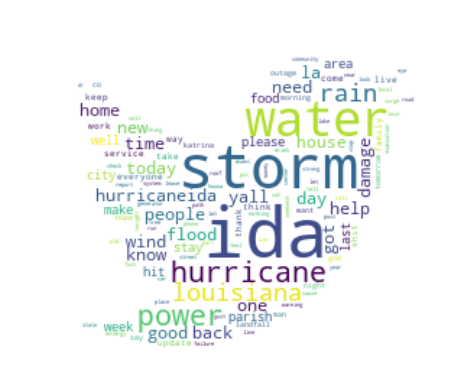

In [40]:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [7]:
new_df.sort_values(by='Frequency', ascending=False).head(50)


,Word,Frequency
0,the,5396
1,to,3734
2,and,3076
3,in,2658
4,a,2563
5,of,2326
6,ida,2163
7,i,1998
8,is,1911
9,for,1796
